In [18]:
import numpy as np
import pandas as pd
import xsimlab as xs
import xsimlab.dot as dot
import vmlab
from vmlab.models import fruit_model

In [38]:
from  importlib import resources

In [27]:
fruit_model = fruit_model.drop_processes(['fruit_quality','fruit_composition'])

In [43]:
from vmlab.processes.light_interception import LightInterception

@xs.process
class PestsLightInterception(LightInterception):
    """ Compute light interception for photosynthetically active radiation, including damages made by pests.
    """
    pest_impact = xs.variable(intent='in')

    def initialize(self):
        # initialize the base 'LightInterception' class
        super().initialize()
              
    @xs.runtime(args=())
    def run_step(self):

        if np.any(np.isnan(self.sunlit_fraction_col)):
            # initialization of appearing GUs
            nan_sunlit_fractions = np.flatnonzero(np.isnan(self.sunlit_fraction_col))
            self.sunlit_fraction_col[nan_sunlit_fractions] = self.sunlit_fraction_col_default
            self.sunlit_fraction[nan_sunlit_fractions, :] = self.sunlit_fraction_df.iloc[:, self.sunlit_fraction_col[nan_sunlit_fractions]].to_numpy(dtype=np.float32).T

        params = self.parameters

        k_1 = params.k_1
        k_2 = params.k_2
        k_3 = params.k_3
        sunlit_ws = params.sunlit_ws
        e_nleaf2LA_1 = params.e_nleaf2LA_1
        e_nleaf2LA_2 = params.e_nleaf2LA_2

        # GR conversion form J/cm2/h to W/m2
        GR = self.GR / 3600 * 10000

        # photosynthetic active radiation (eq.10-19) :
        self.PAR = GR * k_1 * k_2
        self.PAR_shaded = k_3 * self.PAR

        # leaf area (eq. 11) :
        self.LA = self.pest_impact * e_nleaf2LA_1 * self.nb_leaf ** e_nleaf2LA_2

        self.LA_sunlit = self.sunlit_fraction * sunlit_ws * np.vstack(self.LA)
        self.LA_shaded = np.vstack(self.LA) - self.LA_sunlit

In [44]:
fruit_model_pests = fruit_model.update_processes({'light_interception': PestsLightInterception})
xs.process_info(fruit_model_pests.light_interception)

<PestsLightInterception  (xsimlab process)>
Variables:
    parameter_file_path             [in]
    parameters                     [out]
    nb_gu                           [in] <--- <unknown>.<unknown>
    GR                              [in] <--- Environment.GR
    nb_leaf                         [in] <--- Growth.nb_leaf
    sunlit_fraction_df             [out]
    sunlit_fraction_col_default     [in] The default column index f...
    sunlit_fraction_col          [inout] ('GU',) The column index f...
    sunlit_fraction                [out] ('GU', 'hour') Fraction of...
    LA                             [out] ('GU',) total leaf area pe...
    PAR                            [out] ('hour',) hourly photosynt...
    PAR_shaded                     [out] ('hour',) hourly photosynt...
    LA_sunlit                      [out] ('GU', 'hour') hourly leaf...
    LA_shaded                      [out] ('GU', 'hour') hourly leaf...
    pest_impact                     [in]
Simulation stages:
    in

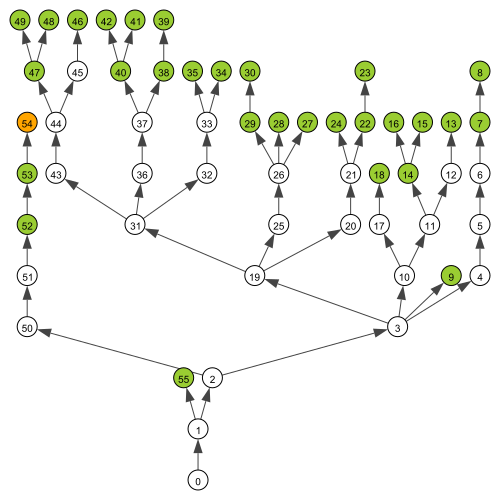

In [51]:
with resources.path('vmlab.data.trees', 'branch_F14_24.csv') as path:
    tree = pd.read_csv(path)
    graph = vmlab.to_graph(tree)

layout = graph.layout_reingold_tilford()
layout.rotate(180)
ig.plot(
    graph, 
    bbox=(0,0,500,500), 
    layout=layout, 
    vertex_label=graph.vs.get_attribute_values('id'), #changement ici de 'name' vers 'id'
    vertex_label_size=10,
    vertex_color=[ 'orange' if f > 0 else 'yellowgreen' if l > 0 else 'white' for f, l in zip(
    graph.vs.get_attribute_values('arch_dev__pot_nb_fruit'),
    graph.vs.get_attribute_values('growth__nb_leaf')
    )])

In [72]:
setup = vmlab.create_setup(
    model=fruit_model_pests,
    tree=tree,
    start_date='2002-06-01',
    end_date='2003-06-01',
    setup_toml='fruit_model.toml',
    current_cycle=3,
    input_vars={
        'light_interception__pest_impact': 0.20,
        'topology__seed': 11,
        'carbon_flow_coef__max_distance_to_fruit': 6,
        'geometry__interpretation_freq': 1,
        'growth__leaf_senescence_enabled': False
    },
    output_vars={
        'photosynthesis': {
            'photo': 'day',
            'Pmax': 'day',
            'D_fruit_avg': 'day'
        },
        'carbon_demand': {
            'D_fruit': 'day',
            'MR_stem': 'day',
            'MR_leaf': 'day',
            'MR_fruit': 'day',
            
        },
        'carbon_allocation': {
            'carbon_supply': 'day',
            'DM_fruit': 'day',
            'reserve_stem_delta': 'day',
            'reserve_leaf_delta': 'day',
            'reserve_nmob_stem_delta': 'day',
            'reserve_nmob_leaf_delta': 'day',
            'remains_1': 'day',
            'required_DM_fruit': 'day'
        },
        'light_interception__sunlit_fraction': 'day'
     }
)

In [73]:
ds_out = vmlab.run(setup, fruit_model_pests, geometry=True)

SceneWidget(scenes=[{'id': 'afaYq8nLOlWUfKApP4gCrPvxN', 'data': b'x\xdaSLrw\xf5\xf7e`Pp\xe0\xe5RPVVd\x00\x020\…

             0% | initialize 

d:\Mes Programmes\miniconda3\envs\vmango-lab\lib\site-packages\xarray\core\utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


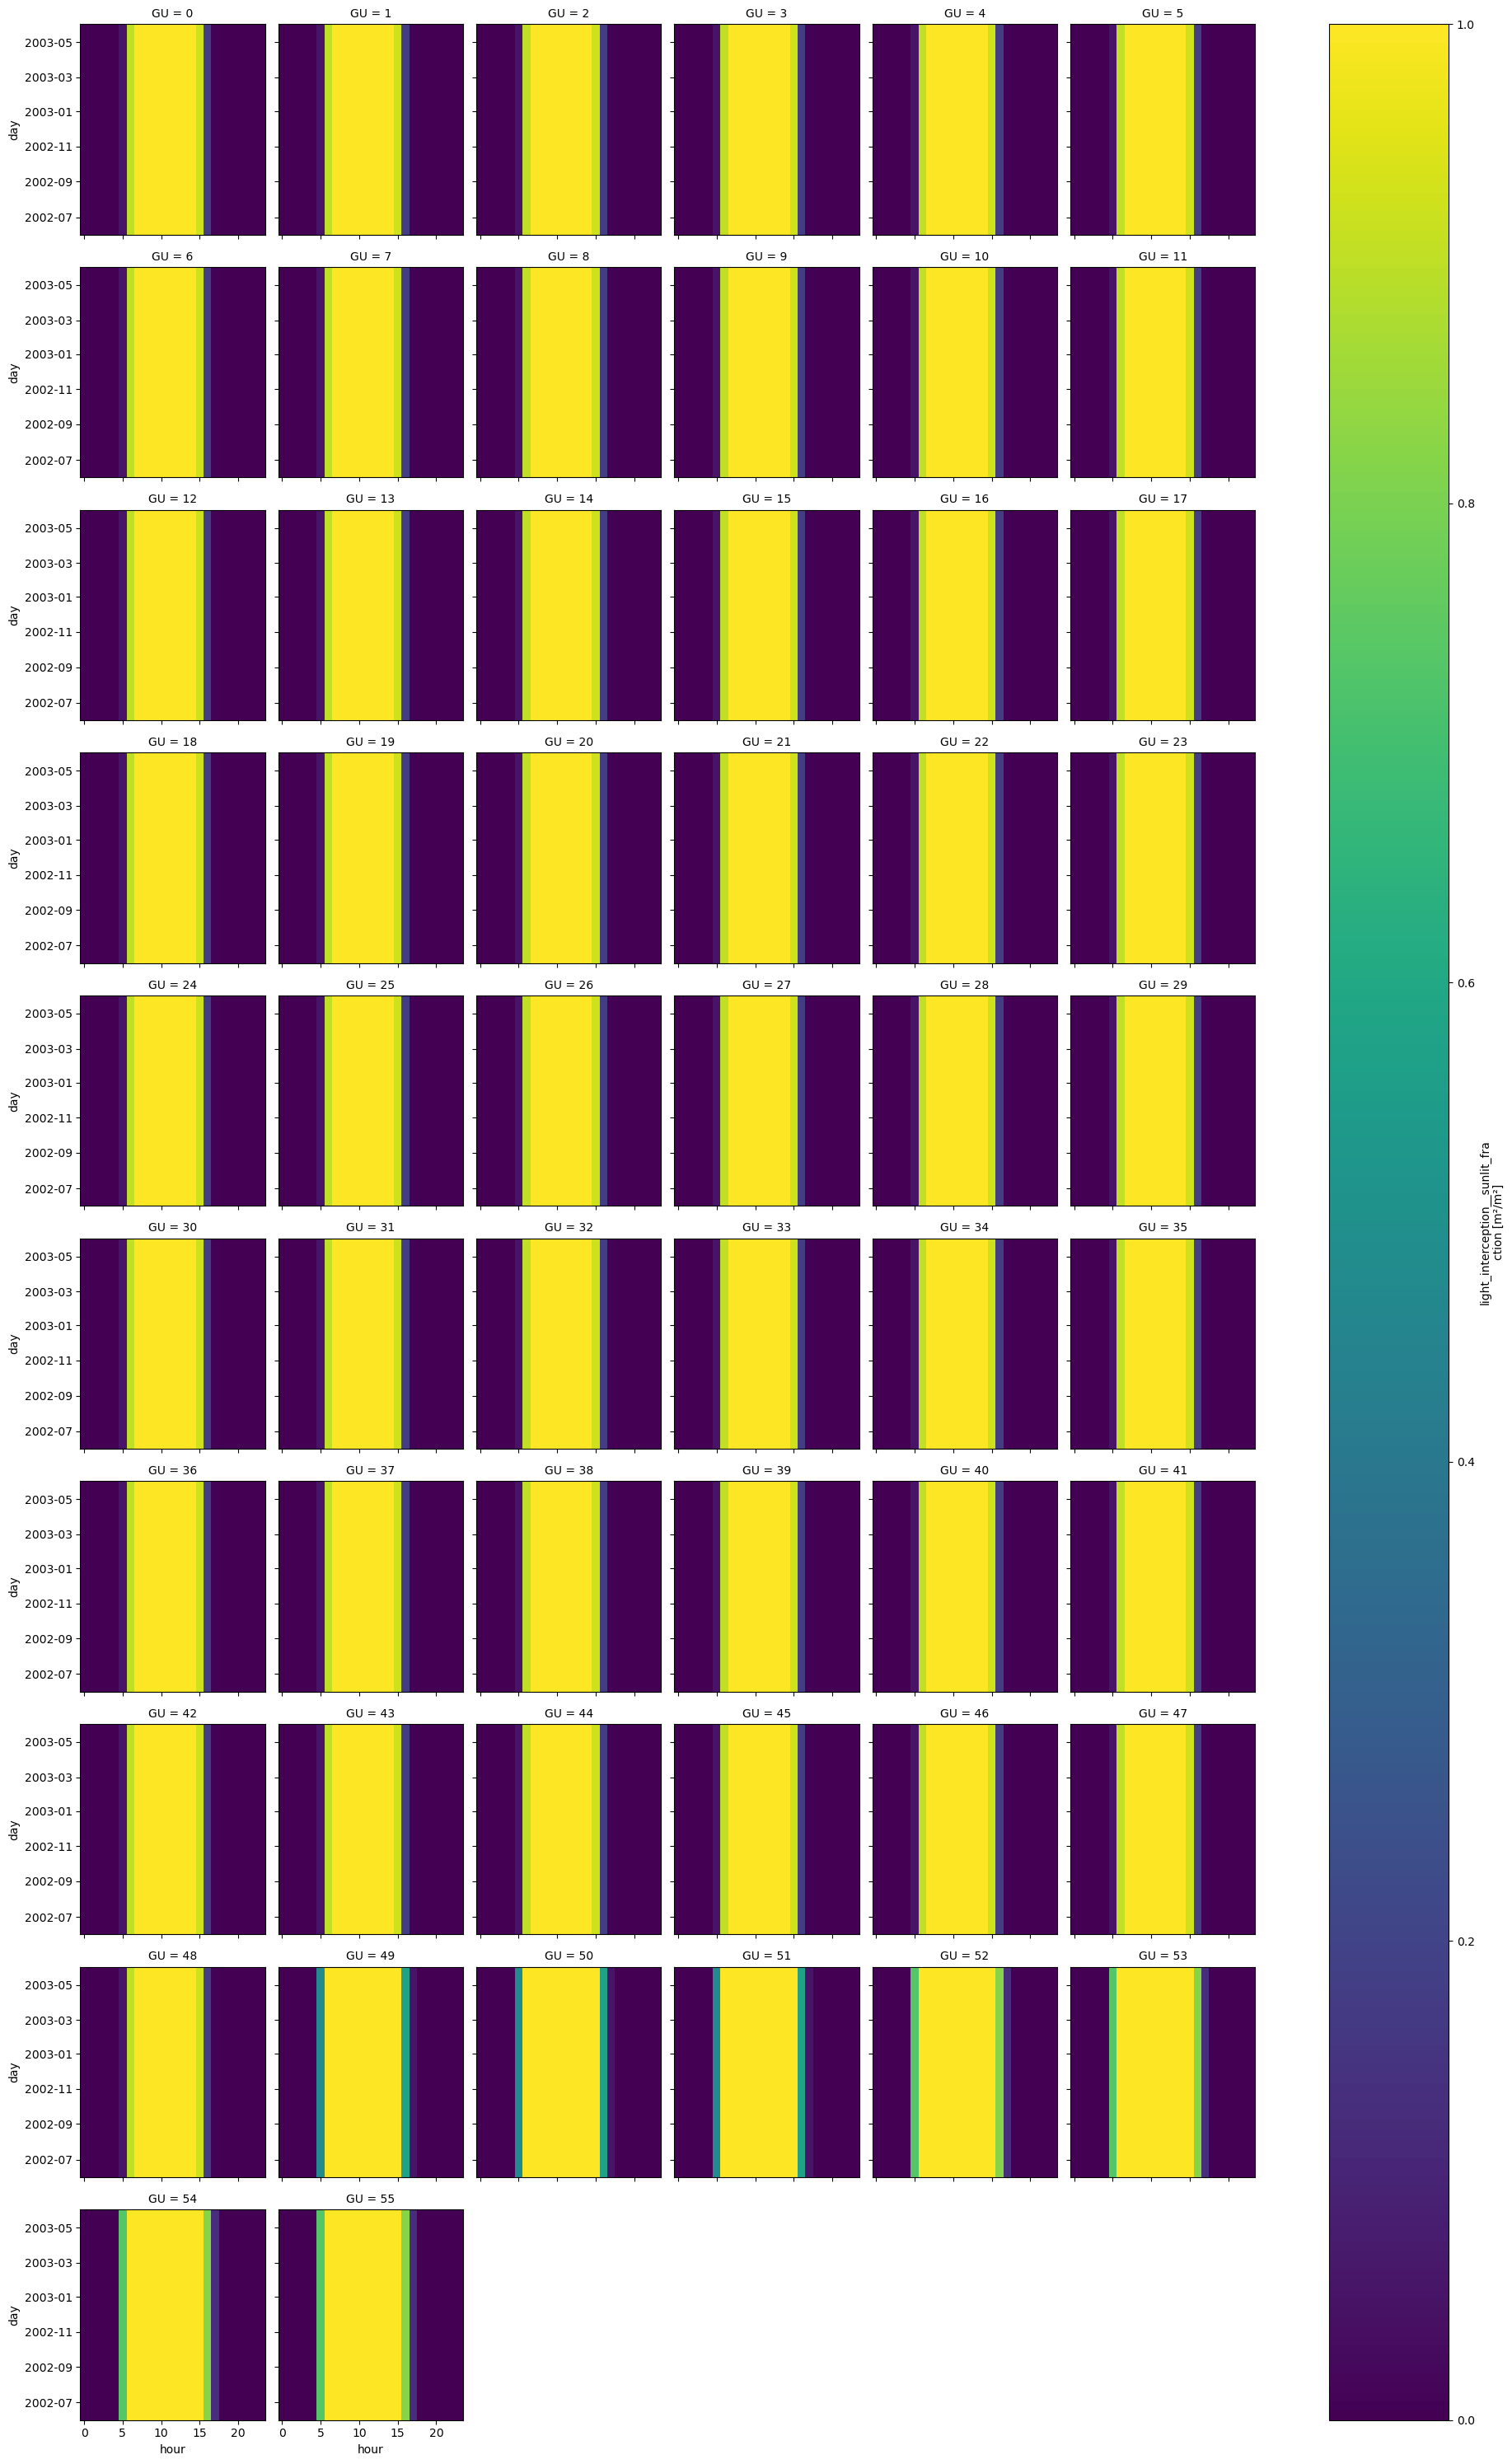

In [64]:
ds_out.light_interception__sunlit_fraction.plot(col='GU', col_wrap=6)

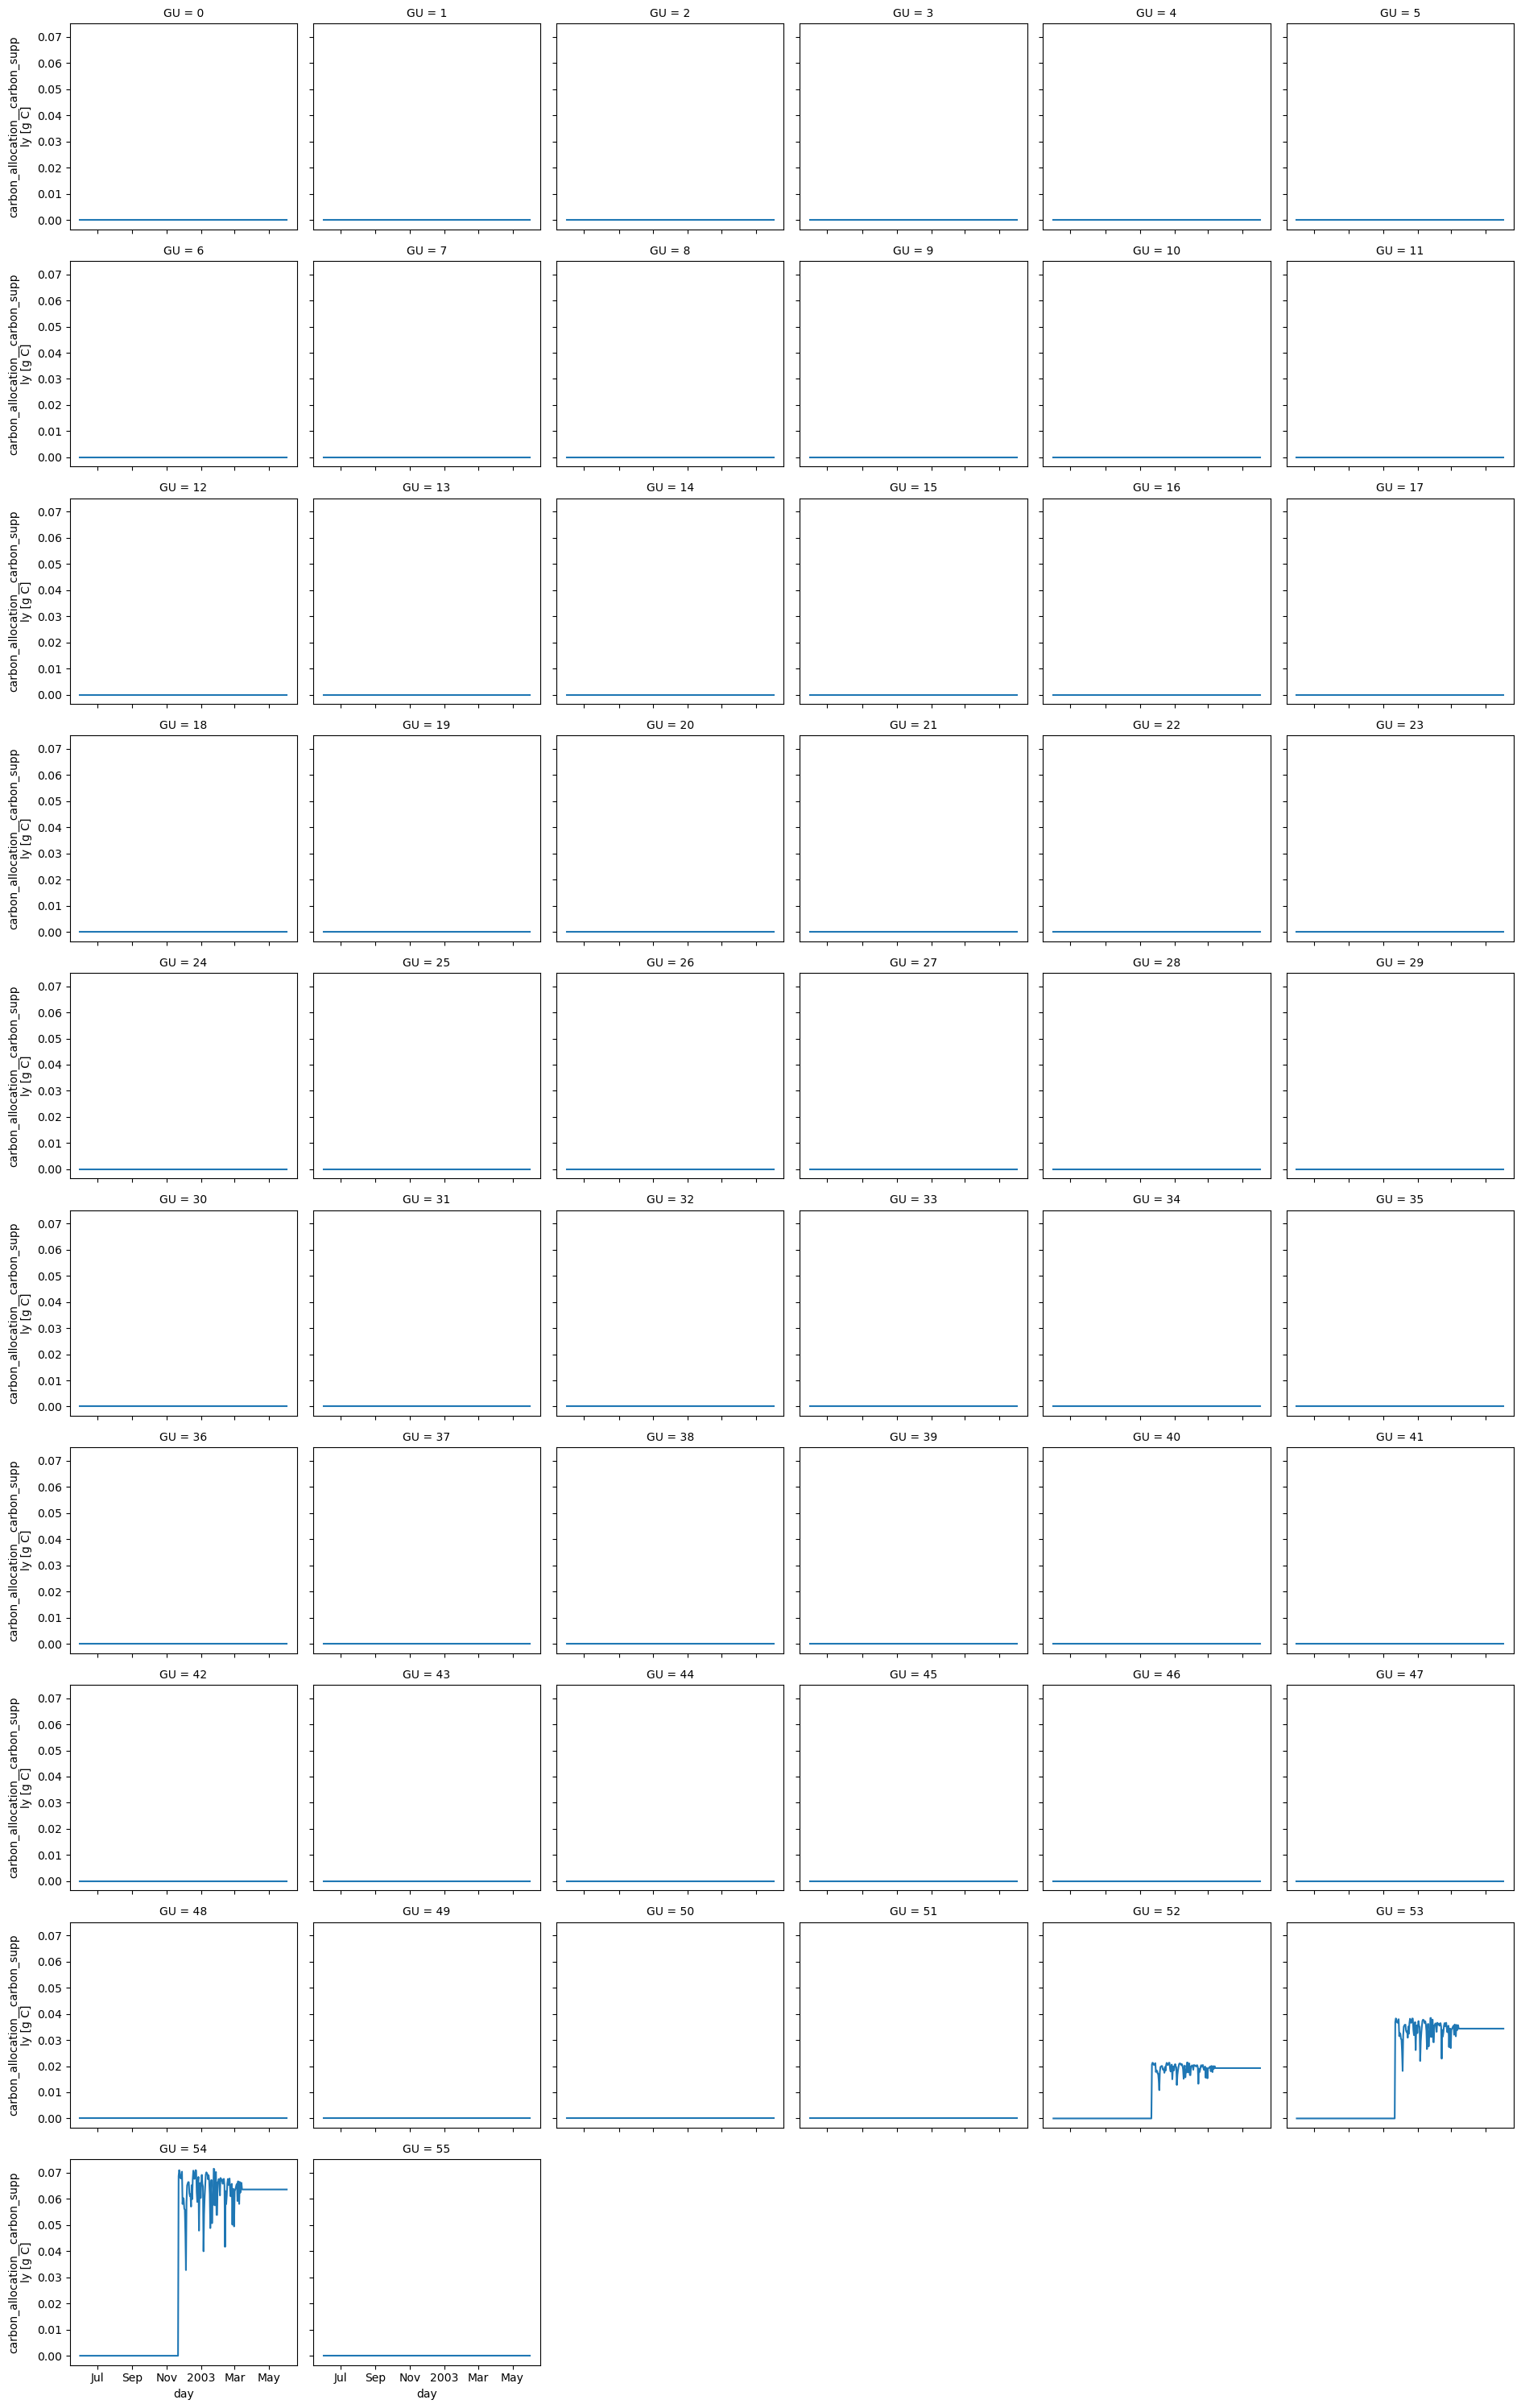

In [67]:
ds_out.carbon_allocation__carbon_supply.plot(col='GU', col_wrap=6)

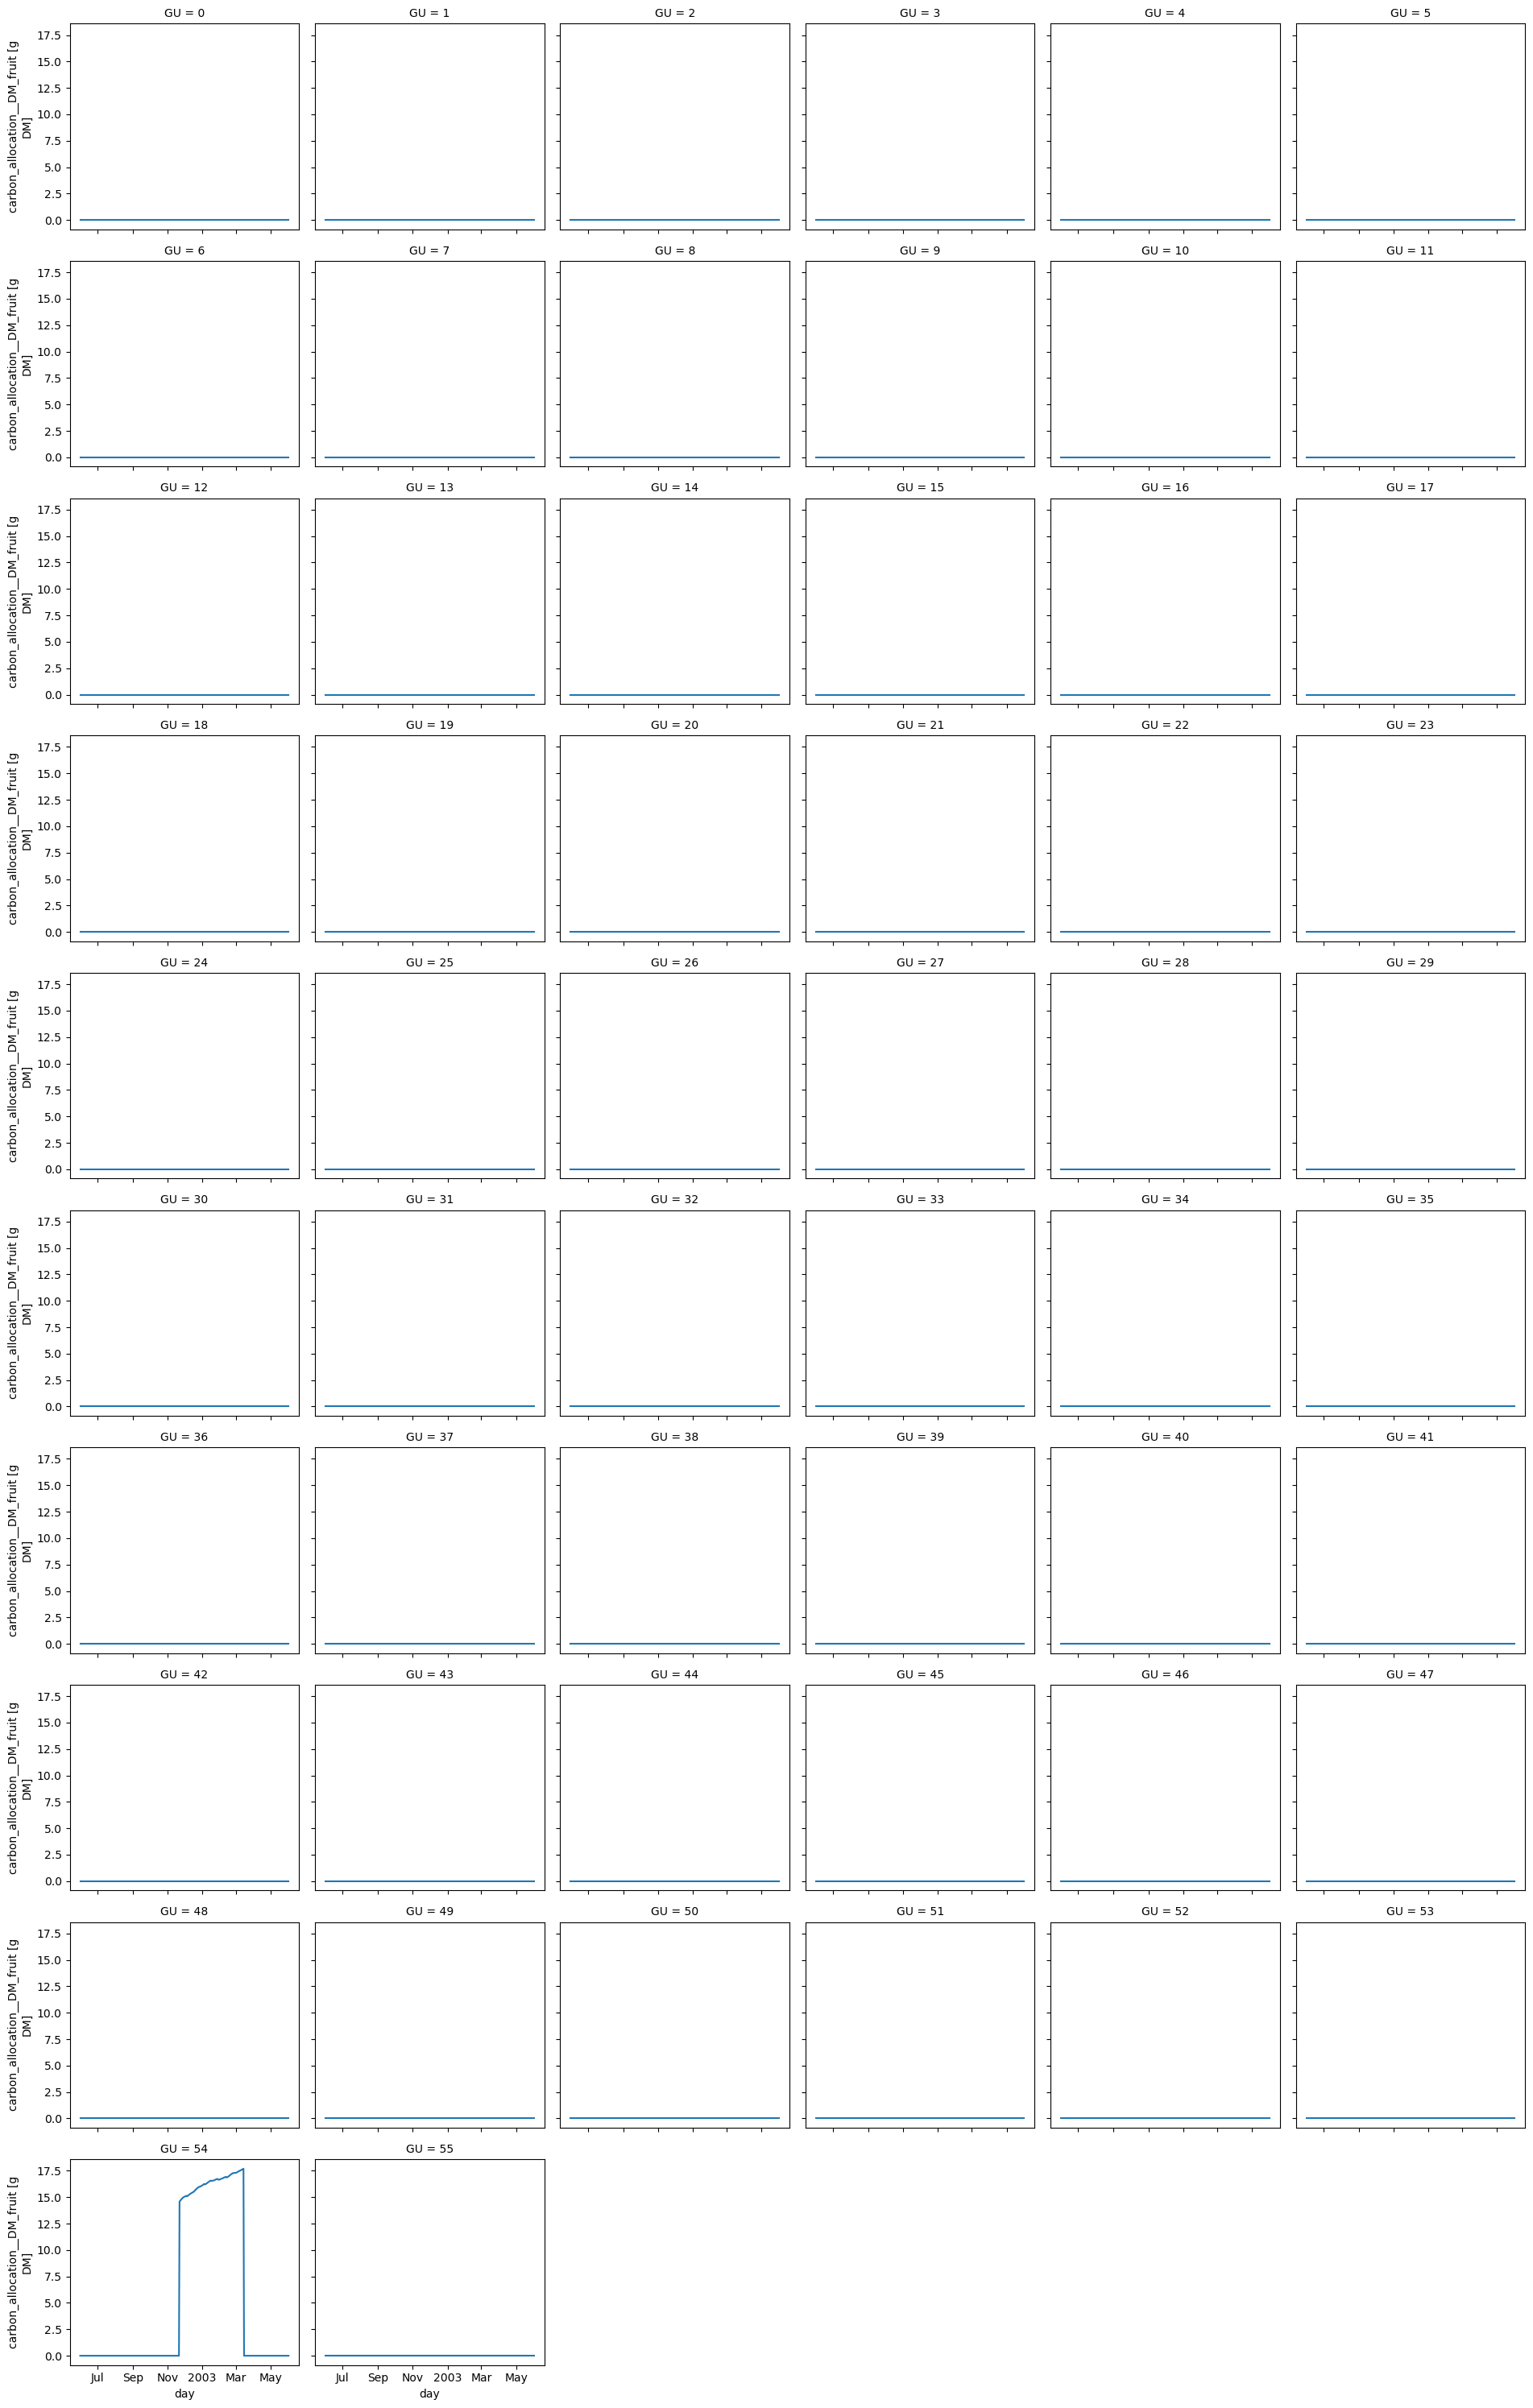

In [74]:
ds_out.carbon_allocation__DM_fruit.plot(col='GU', col_wrap=6)

# Sans attaque de bioaggresseurs :

In [75]:
setup = vmlab.create_setup(
    model=fruit_model,
    tree=tree,
    start_date='2002-06-01',
    end_date='2003-06-01',
    setup_toml='fruit_model.toml',
    current_cycle=3,
    input_vars={
        'topology__seed': 11,
        'carbon_flow_coef__max_distance_to_fruit': 6,
        'geometry__interpretation_freq': 1,
        'growth__leaf_senescence_enabled': False
    },
    output_vars={
        'photosynthesis': {
            'photo': 'day',
            'Pmax': 'day',
            'D_fruit_avg': 'day'
        },
        'carbon_demand': {
            'D_fruit': 'day',
            'MR_stem': 'day',
            'MR_leaf': 'day',
            'MR_fruit': 'day',
            
        },
        'carbon_allocation': {
            'carbon_supply': 'day',
            'DM_fruit': 'day',
            'reserve_stem_delta': 'day',
            'reserve_leaf_delta': 'day',
            'reserve_nmob_stem_delta': 'day',
            'reserve_nmob_leaf_delta': 'day',
            'remains_1': 'day',
            'required_DM_fruit': 'day'
        },
        'light_interception__sunlit_fraction': 'day'
     }
)

ds_out = vmlab.run(setup, fruit_model, geometry=True)

SceneWidget(scenes=[{'id': 'hVEdcn50hV4fe2kVOSrW4s0DQ', 'data': b'x\xdaSLrw\xf5\xf7e`Pp\xe0\xe5RPVVd\x00\x020\…

             0% | initialize 

d:\Mes Programmes\miniconda3\envs\vmango-lab\lib\site-packages\xarray\core\utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


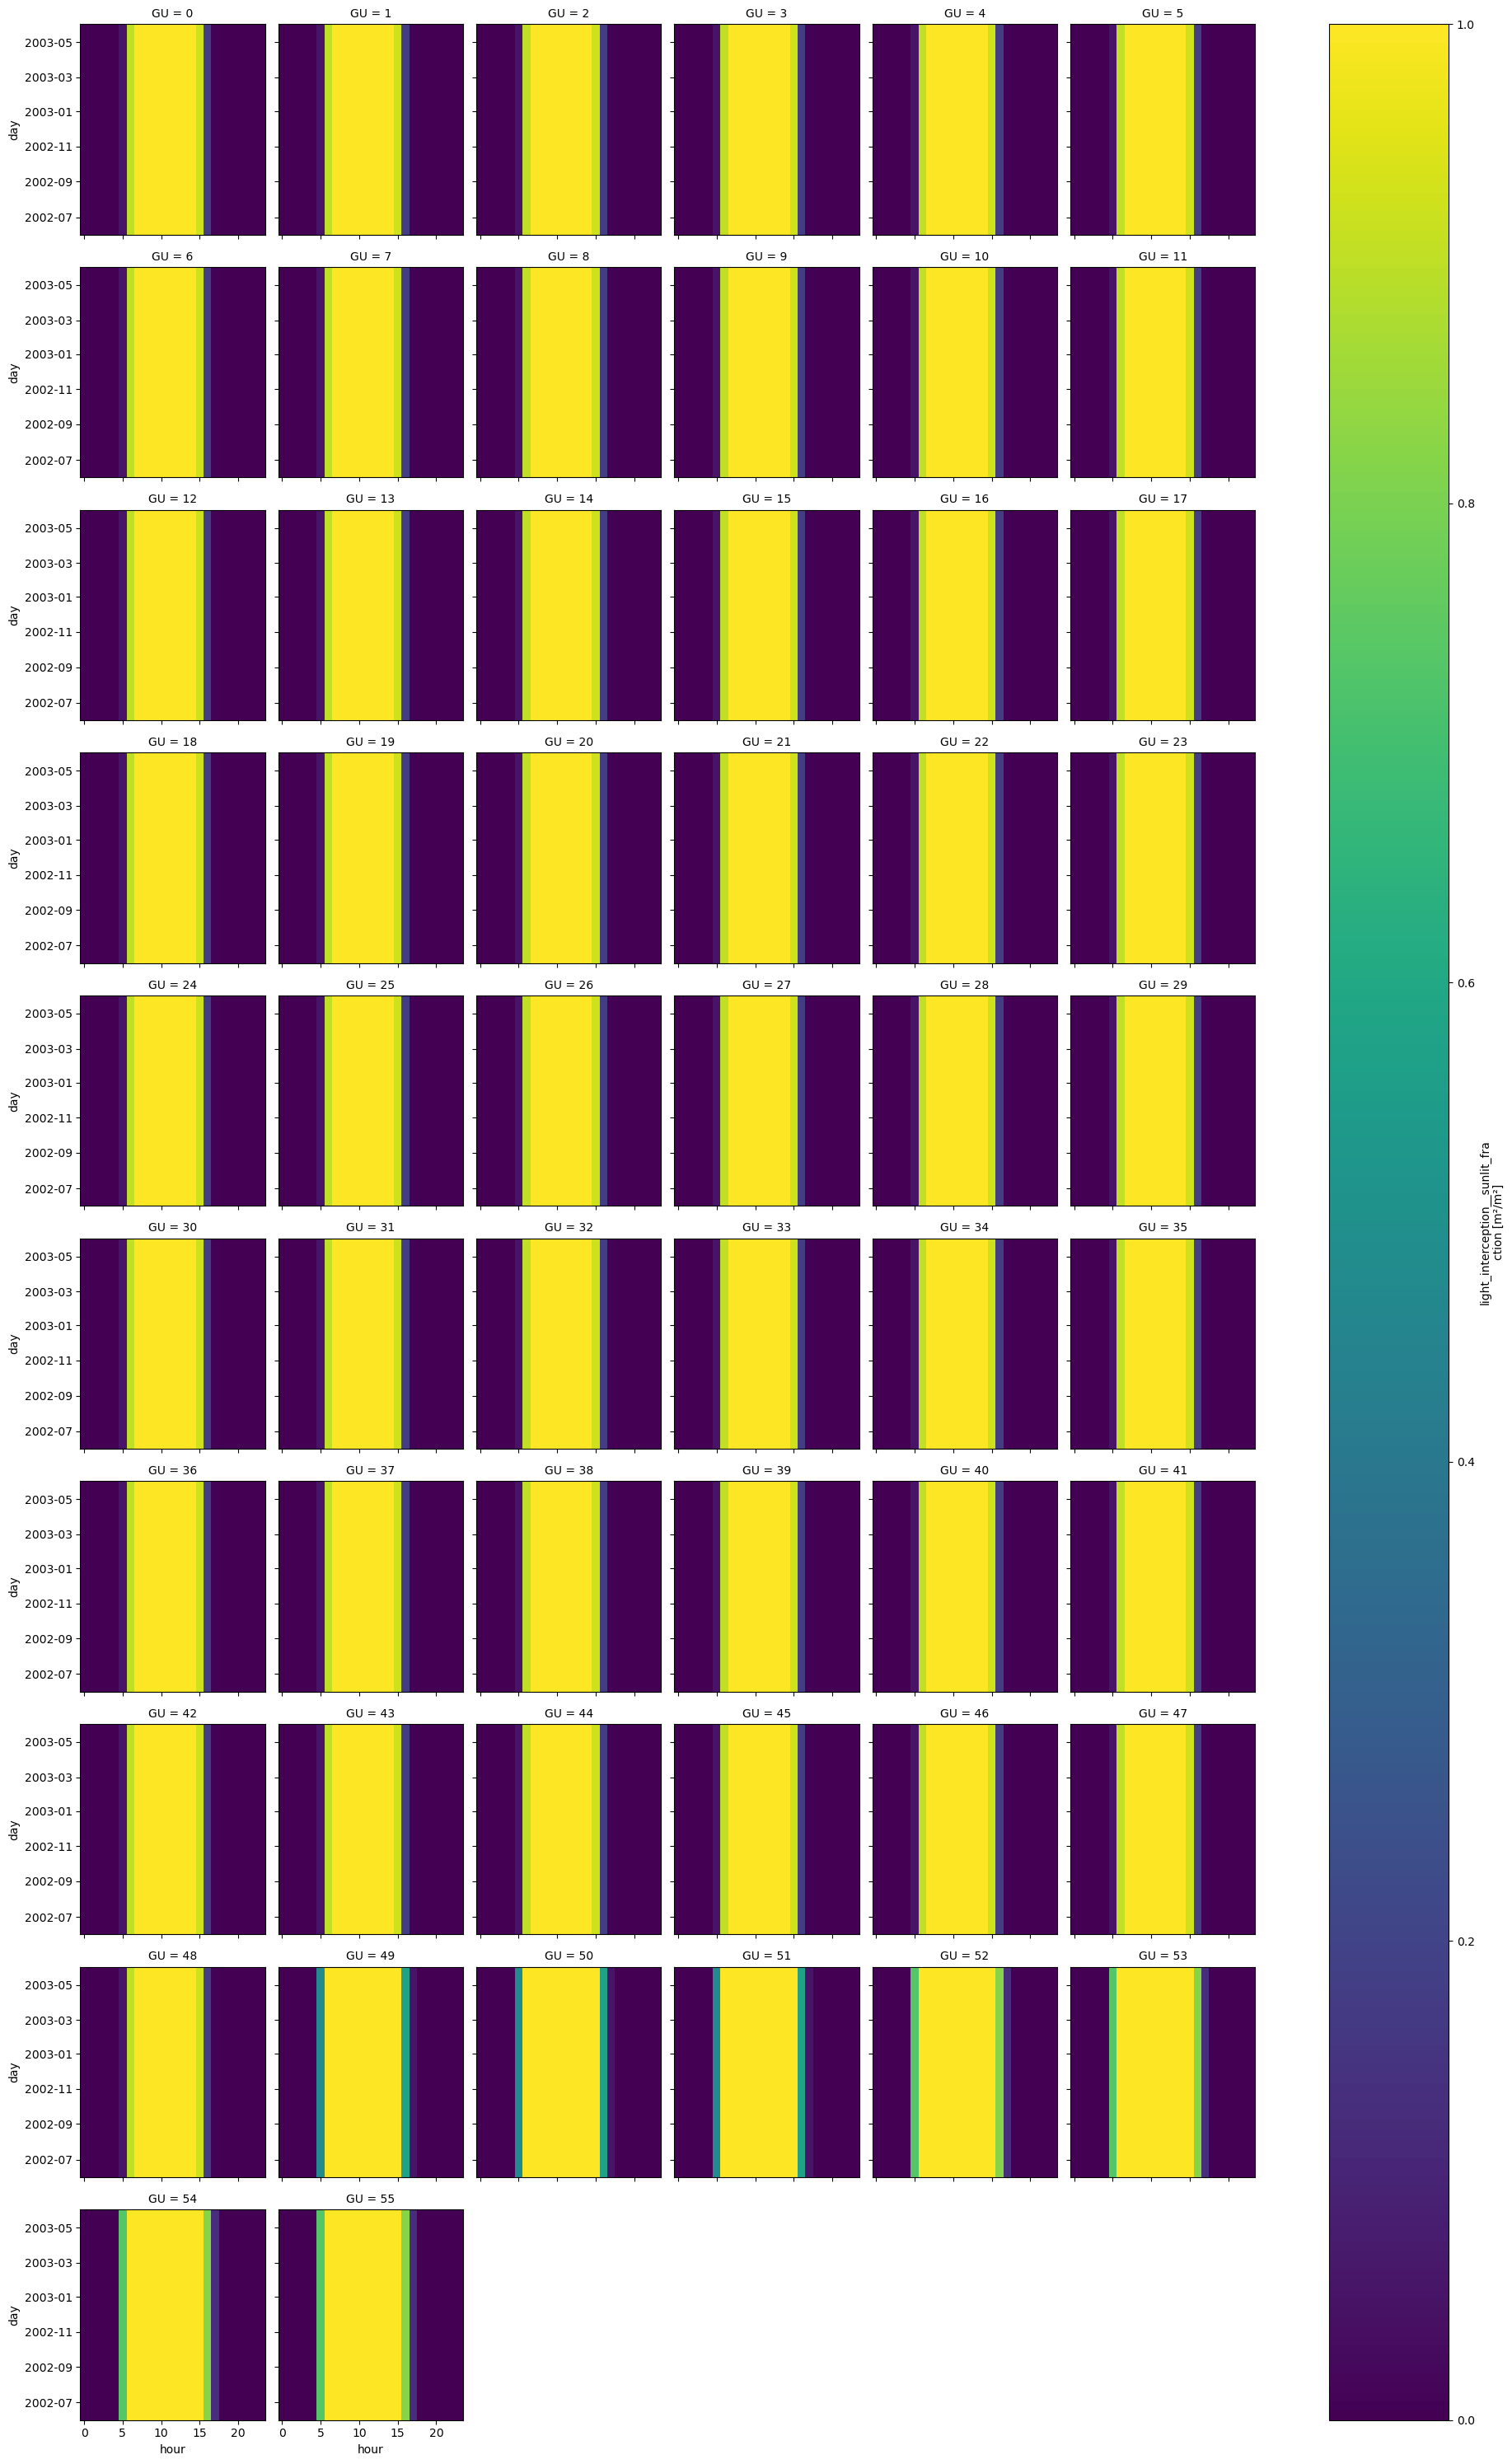

In [70]:
ds_out.light_interception__sunlit_fraction.plot(col='GU', col_wrap=6)

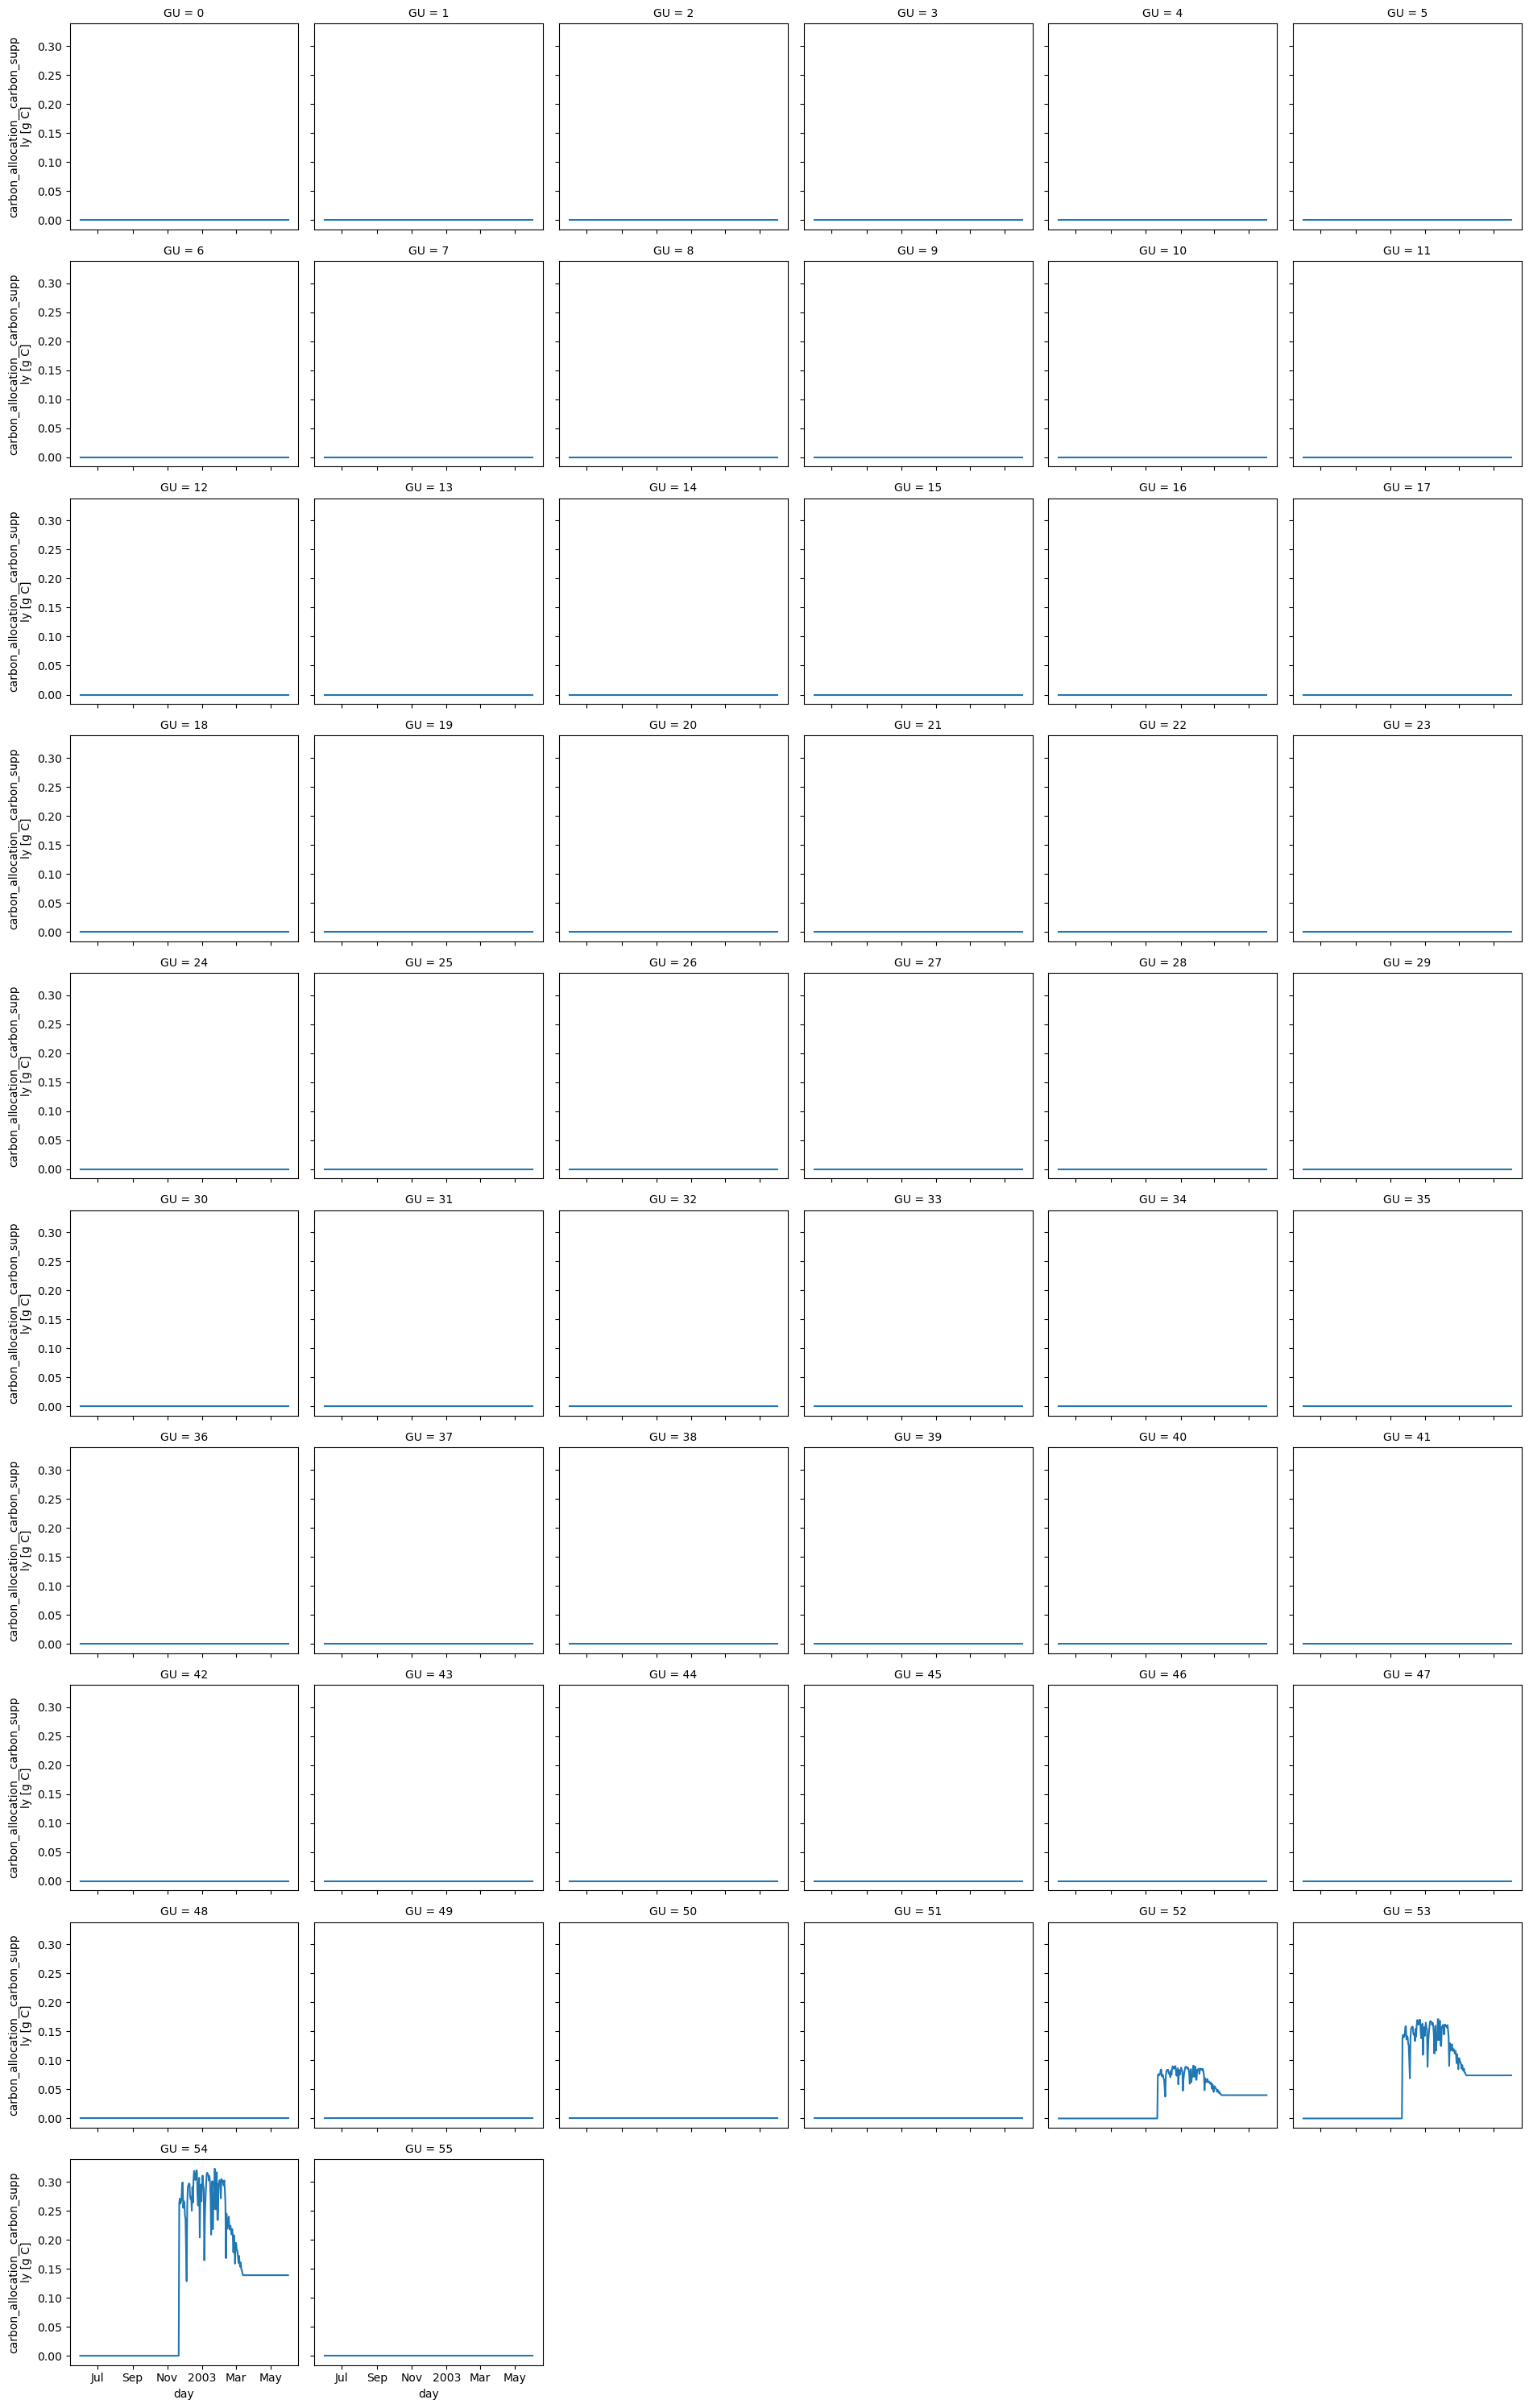

In [71]:
ds_out.carbon_allocation__carbon_supply.plot(col='GU', col_wrap=6)

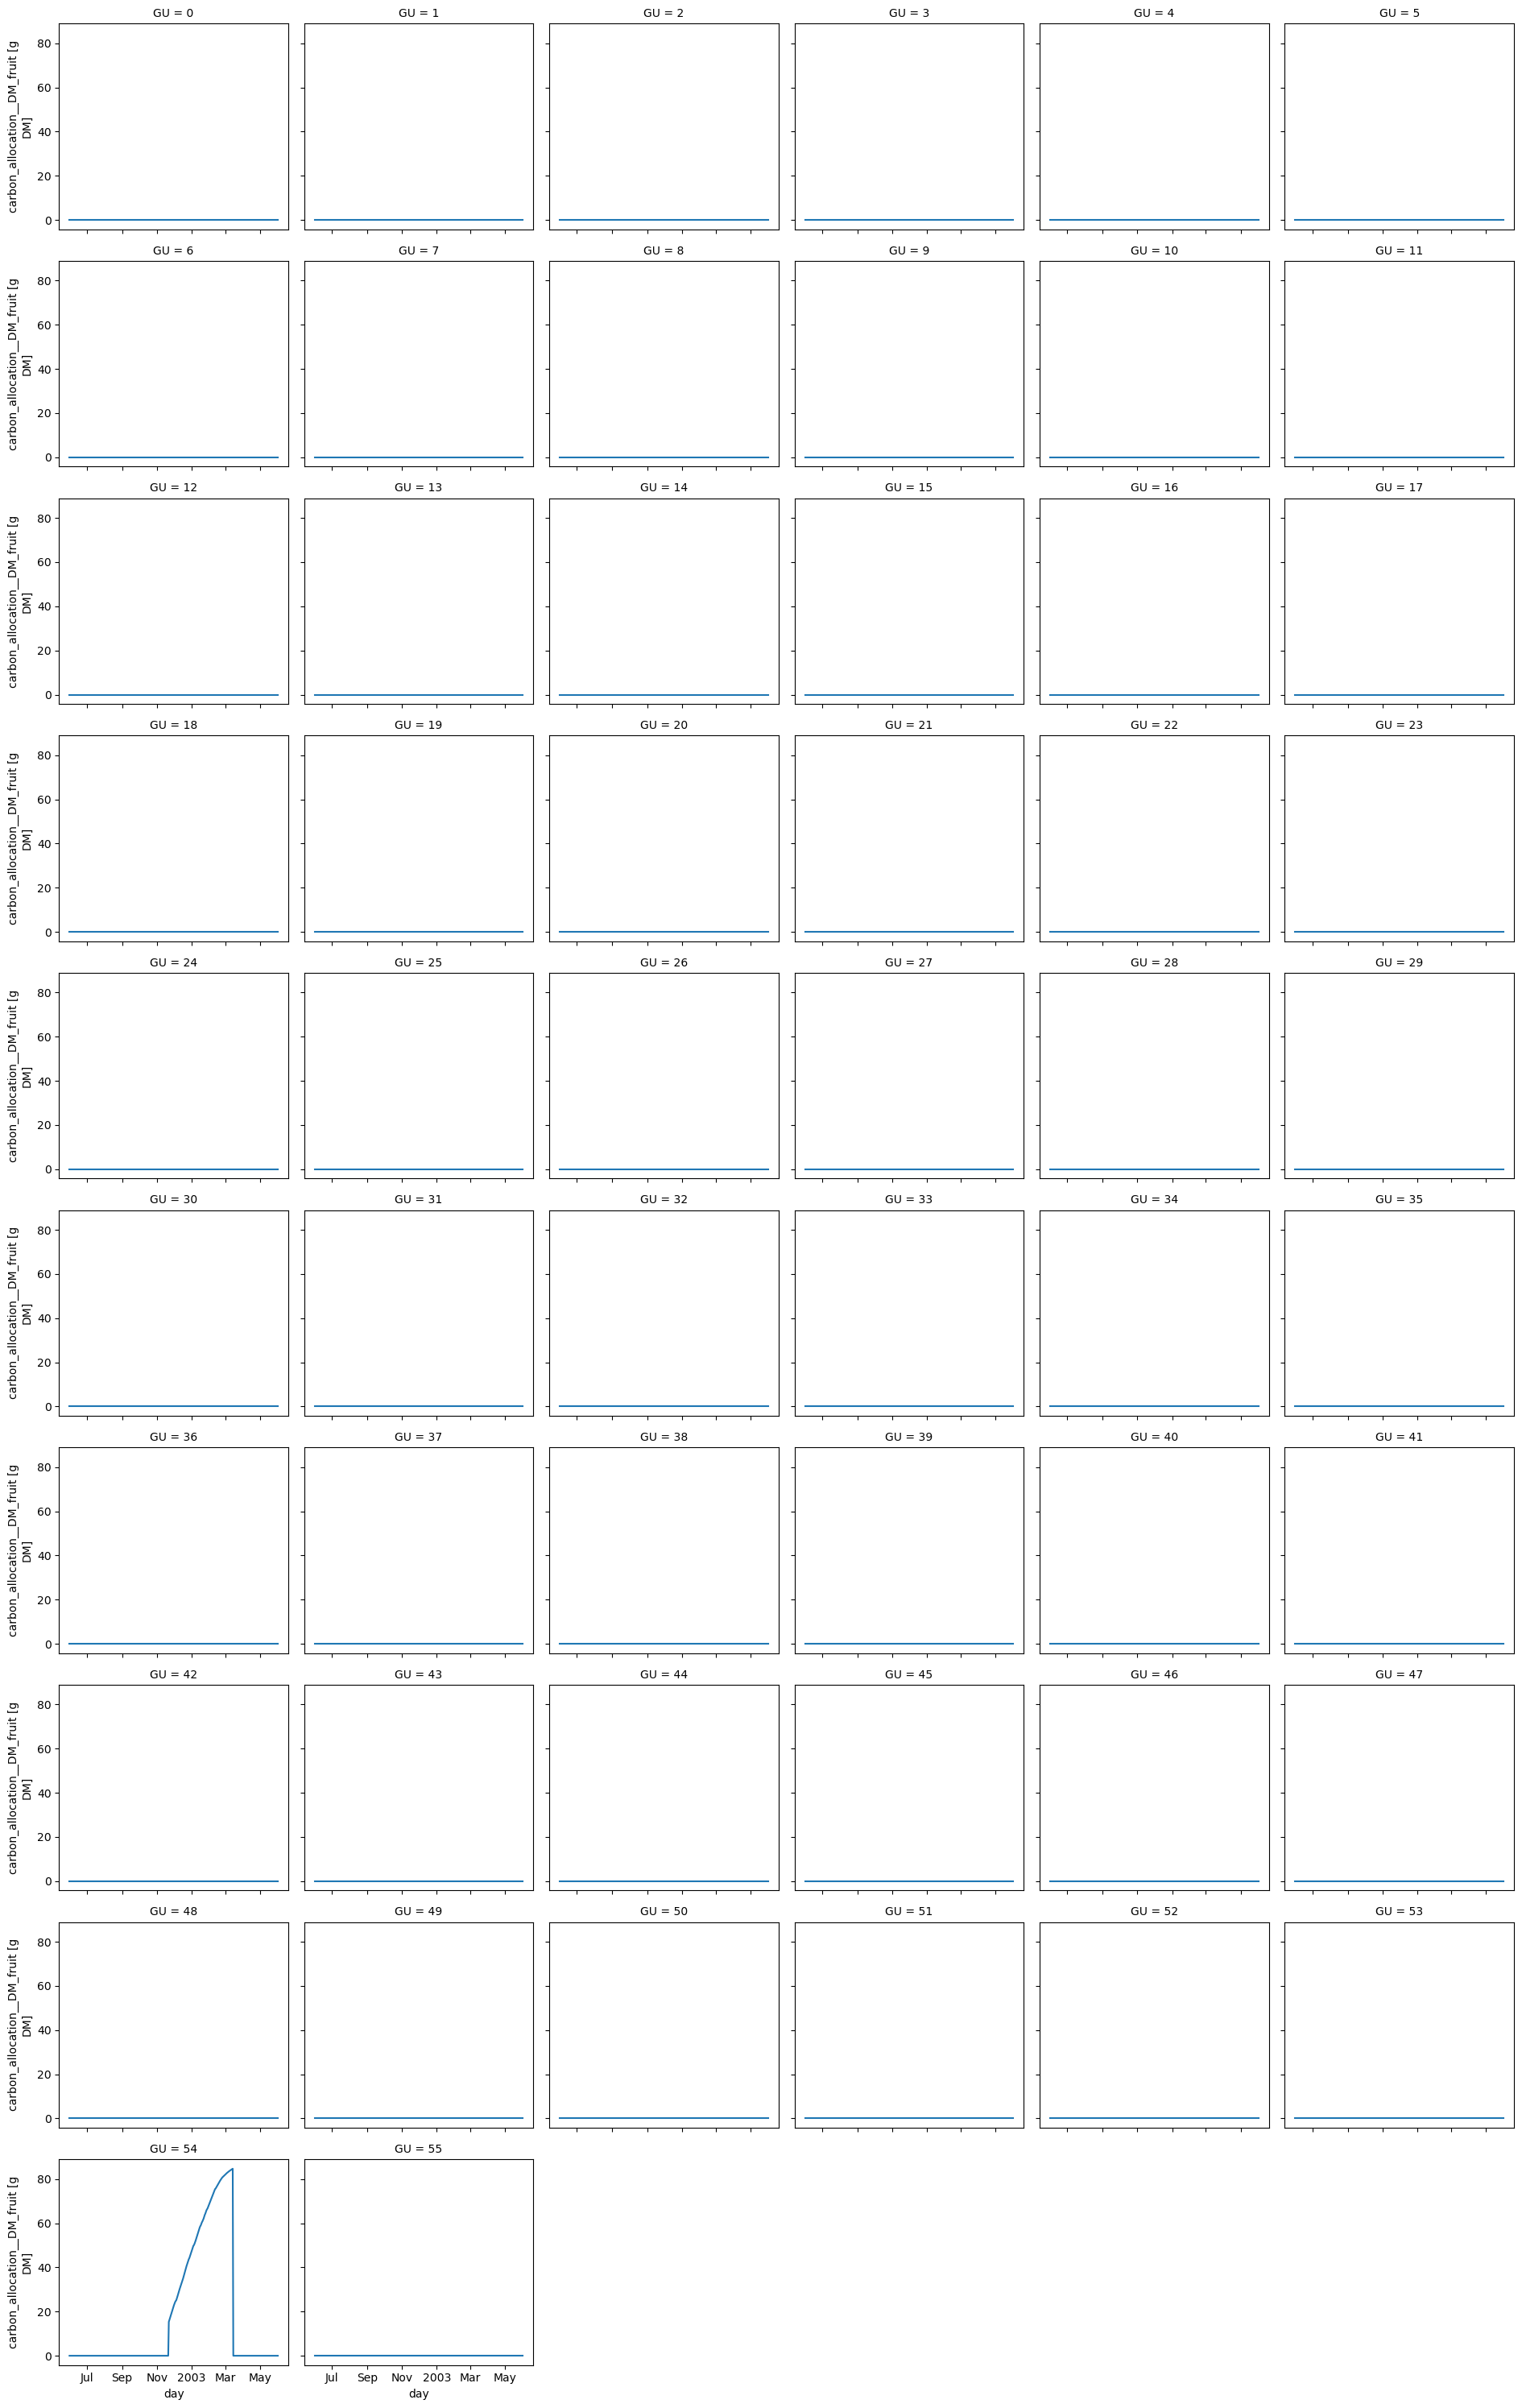

In [76]:
ds_out.carbon_allocation__DM_fruit.plot(col='GU', col_wrap=6)